In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Compute Gallery,469.323751,11.733094,22.116530,40
Open Source/GitHub,659.767532,109.961255,181.059953,6
C# Basics,710.259651,22.911602,33.586772,31
WSL + Kali Linux,772.174418,85.797158,264.045067,9
Azure Private DNS,785.243618,41.328611,65.680317,19
RAG Project,908.647992,56.790499,123.563006,16
Azure AD Authentication,983.229080,75.633006,178.760929,13
Azure Functions + Visual Studio,1072.686662,82.514359,288.005976,13
Email Auth and Security,1104.340317,92.028360,189.275074,12
Audit Report Tracker (Sharepoint List),1107.033130,100.639375,275.151920,11


# Histogram

sum of ages: ~48741.36


<Axes: >

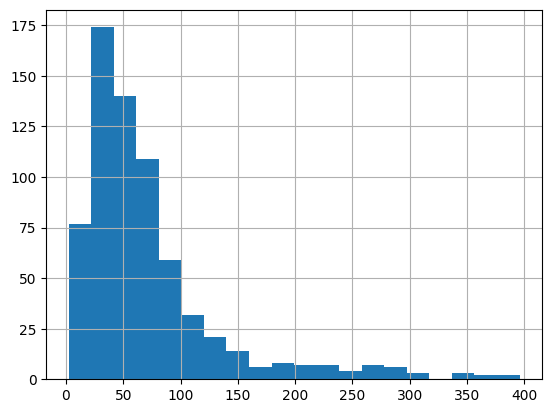

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [ ]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
n=4
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 681
Total card age: 48741.36


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
177,Open Source/GitHub,README.md\n\nA markdown file at the root of a ...,fa7339e54e6cae2d01eec1f8a2af3d25,181.059953,109.961255,181.059953,659.767532,0.142888,6,0,0,-181.059953
409,Open Source/GitHub,Hotfix\n\nAn urgent fix applied to a project t...,07a66c6061571c256143d25116985a42,165.653343,109.961255,181.059953,659.767532,0.142888,6,1,0,-165.653343
633,Open Source/GitHub,Good First Issue\n\nA label for beginner-frien...,ee4aff4c065b819d4ed6d2b8c3820ee9,103.269514,109.961255,181.059953,659.767532,0.142888,6,2,0,-103.269514
178,Open Source/GitHub,Contributor\n\nAn individual who contributes c...,38bb149465fee49766142779308d79d1,95.203280,109.961255,181.059953,659.767532,0.142888,6,3,0,-95.203280
231,WSL + Kali Linux,/etc/wsl.conf\nA configuration file in Linux d...,d7247497d7a6816591f382a140abb013,264.045067,85.797158,264.045067,772.174418,0.296586,9,0,0,-264.045067
458,WSL + Kali Linux,"wsl with Docker\nDocker can run on WSL 2, whic...",35482ece9a9fc66928fea68605960010,164.722935,85.797158,264.045067,772.174418,0.296586,9,1,0,-164.722935
232,WSL + Kali Linux,"wsl --update\nUpdates the WSL 2 Linux kernel, ...",ca31a4ff6b4b1feaa1d34462308ee8cb,69.426522,85.797158,264.045067,772.174418,0.296586,9,2,0,-69.426522
459,WSL + Kali Linux,Wireshark Capture Filter\nA set of rules used ...,845ea91c26ec16e6c08be40876be1cd0,61.661995,85.797158,264.045067,772.174418,0.296586,9,3,0,-61.661995
153,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,275.151920,100.639375,275.151920,1107.033130,0.049911,11,0,0,-275.151920
386,Audit Report Tracker (Sharepoint List),List Columns Endpoint (for getting column info...,3bd5c040a578b34b790adce8588c4036,212.033660,100.639375,275.151920,1107.033130,0.049911,11,1,0,-212.033660



## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [21]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
32,Azure Developer Associate,Which Azure Monitor table holds platform metri...,52fbf976aa2ccee89121f7b5694acfce,395.811002,80.667424,395.811002,4436.708327,0.461568,55,0,0,-395.811002
19,PowerShell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,384.154802,96.730873,384.154802,3579.042297,0.648895,37,0,0,-384.154802
51,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,371.405899,94.944849,371.405899,4937.132139,0.712410,52,0,0,-371.405899
257,PowerShell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,357.430766,96.730873,384.154802,3579.042297,0.648895,37,1,0,-357.430766
69,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,353.720746,79.849738,353.720746,1916.393710,0.806925,24,0,0,-353.720746
77,FSLogix,"During a first-time sign-in, FSLogix creates t...",f2d84db5972e92abd44bdb7e0c5686a7,343.488850,74.414918,343.488850,2530.107202,0.950636,34,0,0,-343.488850
312,FSLogix,Q: Which format does FSLogix use to store user...,2502a81cff9047e83fa1e04a99225de5,338.150482,74.414918,343.488850,2530.107202,0.950636,34,1,0,-338.150482
89,Vocab,"Red Side Story, FForde\nParboil\nPronunciation...",1ee9362f92872e44aac4c6b02749add8,312.993355,60.906673,312.993355,4933.440505,0.648664,81,0,0,-312.993355
122,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,305.717707,98.102440,305.717707,3825.995151,0.760750,39,0,0,-305.717707
116,Logging in Python,Q: What should you do to ensure that logging.b...,b3bbc2d622ec1c54b26be4ee9548cdd4,304.631551,95.080360,304.631551,1616.366116,0.658490,17,0,0,-304.631551


In [18]:
existing_cards.head(10).sum()

head                   Open Source/GitHubOpen Source/GitHubOpen Sourc...
body                   README.md\n\nA markdown file at the root of a ...
hash                   fa7339e54e6cae2d01eec1f8a2af3d2507a66c6061571c...
age                                                          1592.228189
subject_mean_age                                              984.312402
subject_highest_age                                          2330.723919
subject_age_sum                                              7941.834057
head_random_roll                                                1.857715
frequency                                                             82
count                                                                 13
n_fold                                                                 0
neg_age                                                     -1592.228189
dtype: object

In [19]:
existing_cards['age'].mean()

71.57322010600478